In [1]:
import matplotlib.pyplot as plt
import scipy as sp
from scipy.io import loadmat
import numpy as np
import time
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import data

import sys
sys.path.append("../../../LocalGraphClustering/")
sys.path.append("../../../LocalGraphClustering/notebooks/")

from localgraphclustering import *

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import multiprocessing as mp

def clutser_improvement(g,ratio,rholist,nprocs):
    records = []
    def wrapper(q_in,q_out):
        while True:
            seed = q_in.get()
            if seed is None:
                break
            gamma = 0.01/0.99
            alpha = 1.0-1.0/(1.0+gamma)
            for rho in rholist:
                l1reg_output = spectral_clustering(g,[seed],rho=rho,alpha=alpha,method="l1reg-rand")
                mqi_output = flow_clustering(g,l1reg_output[0],method="mqi_weighted")
                sl_output1 = flow_clustering(g,l1reg_output[0],method="sl_weighted",delta=0.01)
                sl_output2 = flow_clustering(g,l1reg_output[0],method="sl_weighted",delta=0.1)
                sl_output3 = flow_clustering(g,l1reg_output[0],method="sl_weighted",delta=1)
                print(rho,len(l1reg_output[0]),len(mqi_output[0]),len(sl_output1[0]),len(sl_output2[0]),len(sl_output3[0]))
                q_out.put((rho,"node",l1reg_output[1],mqi_output[1],sl_output1[1],sl_output2[1],sl_output3[1]))
            for rho in rholist:
                R = [seed]
                R.extend(g.neighbors(seed))
                l1reg_output = spectral_clustering(g,R,rho=rho,alpha=alpha,method="l1reg-rand")
                mqi_output = flow_clustering(g,l1reg_output[0],method="mqi_weighted")
                sl_output1 = flow_clustering(g,l1reg_output[0],method="sl_weighted",delta=0.01)
                sl_output2 = flow_clustering(g,l1reg_output[0],method="sl_weighted",delta=0.1)
                sl_output3 = flow_clustering(g,l1reg_output[0],method="sl_weighted",delta=1)
                print(rho,len(l1reg_output[0]),len(mqi_output[0]),len(sl_output1[0]),len(sl_output2[0]),len(sl_output3[0]))
                q_out.put((rho,"set",l1reg_output[1],mqi_output[1],sl_output1[1],sl_output2[1],sl_output3[1]))
    n = g._num_vertices
    np.random.seed(seed=123)
    seeds = np.random.choice(range(n),size=int(ratio*n), replace=False)
    q_in,q_out = mp.Queue(),mp.Queue()
    procs = [mp.Process(target=wrapper,args=(q_in,q_out)) for i in range(nprocs)]
    for seed in seeds:
        q_in.put(seed)
    for i in range(nprocs):
        q_in.put(None)
    for p in procs:
        p.start()
    ncounts = 0
    t1 = time.time()
    while ncounts < 2*len(rholist)*len(seeds):
        ncounts += 1
        record = q_out.get()
        print(ncounts,2*len(rholist)*len(seeds),record[2],record[3],record[4],record[5],record[6])
        print(time.time()-t1)
        records.append(record)
    for p in procs:
        p.join()
    return records

#graph = GraphLocal("com-orkut.ungraph.txt")
graph = GraphLocal("../../dataset/lawlor-spectra-k32.edgelist","edgelist")
g = graph.largest_component()
ratio = 0.001
rholist = [1.0e-10,1.0e-9,1.0e-8]
records = clutser_improvement(g,ratio,rholist,80)

In [3]:
# import pickle

In [4]:
# rptr = open("ncp_records4.p","rb")
# records = pickle.load(rptr)
# rptr.close()

In [51]:
improvement = np.array([[i[3]/i[2],i[4]/i[2],i[5]/i[2],i[6]/i[2]] for i in records])

In [52]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

/homes/liu1740/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/homes/liu1740/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/homes/liu1740/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/homes/liu1740/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



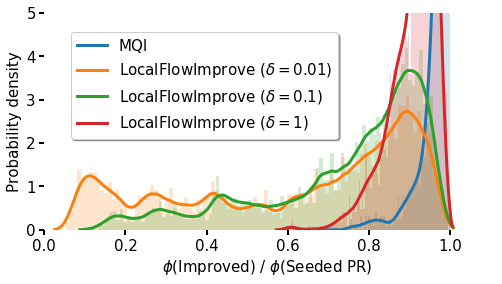

In [53]:
import seaborn as sns

f, axes = plt.subplots(1,1,figsize=(8,4),gridspec_kw={"wspace":0.05})

ax = axes
# Iterate through the five airlines
for i in range(improvement.shape[1]):
    subset = improvement[:,i]
    if i == 0:
        sns.distplot(subset, hist = True, kde = True,
                     kde_kws = {'linewidth': 3,"gridsize":300,"kernel":"tri","bw":0.025,"clip":(0,1),"cut":0.005},
                     hist_kws = {"alpha" : 0.2},
                     ax=ax,
                     norm_hist=True,bins=100,color=colors[i])
    elif i == 3:
        sns.distplot(subset, hist = True, kde = True,
                     kde_kws = {'linewidth': 3,"gridsize":300,"kernel":"tri","bw":0.03,"clip":(0,0.98),"cut":0.85},
                     hist_kws = {"alpha" : 0.2},
                     ax=ax,
                     norm_hist=True,bins=100,color=colors[i])
    else:
        sns.distplot(subset, hist = True, kde = True,
                     kde_kws = {'linewidth': 3,"gridsize":300,"kernel":"tri","bw":0.04,"clip":(0,0.98),"cut":0.7},
                     hist_kws = {"alpha" : 0.2},
                     ax=ax,
                     norm_hist=True,bins=100,color=colors[i])

f.legend(ax.get_lines(),["MQI",r"LocalFlowImprove ($\delta=0.01$)",r"LocalFlowImprove ($\delta=0.1$)",r"LocalFlowImprove ($\delta=1$)"],
         fancybox=True, shadow=True,fontsize=15,bbox_to_anchor=(0.6,0.9))
ax.set_xlim(0.0001,1.1)
ax.set_ylim(-0.01,5)
ax.set_xlabel(r"$\phi($"+"Improved) / "+r"$\phi($"+"Seeded PR)",fontsize=15)
#ax.set_title("Conductance improvement",fontsize=15)
ax.set_ylabel("Probability density",fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='y', which='both', length=5,width=2)
ax.tick_params(axis='x', which='both', length=5,width=2)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)

plt.show()

f.savefig("cluster_improvement.pdf",format='pdf',bbox_inches='tight')

/homes/liu1740/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/homes/liu1740/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/homes/liu1740/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



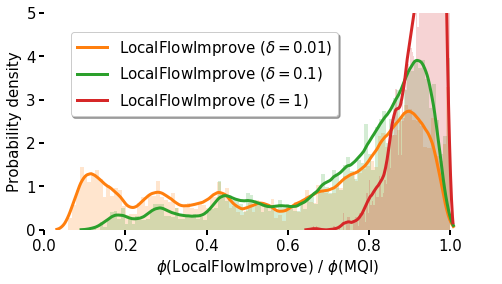

In [54]:
f, axes = plt.subplots(1,1,figsize=(8,4),gridspec_kw={"wspace":0.05})

ax = axes
# Iterate through the five airlines
for i in range(1,improvement.shape[1]):
    subset = improvement[:,i]/improvement[:,0]
    if i == 3:
        sns.distplot(subset, hist = True, kde = True,
                     kde_kws = {'linewidth': 3,"gridsize":300,"kernel":"tri","bw":0.02,"clip":(0,0.99),"cut":0.85},
                     hist_kws = {"alpha" : 0.2},
                     ax=ax,
                     norm_hist=True,bins=100,color=colors[i])
    else:
        sns.distplot(subset, hist = True, kde = True,
                     kde_kws = {'linewidth': 3,"gridsize":300,"kernel":"tri","bw":0.04,"clip":(0,0.98),"cut":0.7},
                     hist_kws = {"alpha" : 0.2},
                     ax=ax,
                     norm_hist=True,bins=100,color=colors[i])

f.legend(ax.get_lines(),[r"LocalFlowImprove ($\delta=0.01$)",r"LocalFlowImprove ($\delta=0.1$)",r"LocalFlowImprove ($\delta=1$)"],
         fancybox=True, shadow=True,fontsize=15,bbox_to_anchor=(0.6,0.9))
ax.set_xlim(0.0001,1.1)
ax.set_ylim(-0.01,5)
ax.set_xlabel(r"$\phi($"+"LocalFlowImprove) / "+r"$\phi($"+"MQI)",fontsize=15)
#ax.set_title("Conductance improvement",fontsize=15)
ax.set_ylabel("Probability density",fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='y', which='both', length=5,width=2)
ax.tick_params(axis='x', which='both', length=5,width=2)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)

plt.show()

f.savefig("cluster_improvement_MQI.pdf",format='pdf',bbox_inches='tight')